Here is my first step: data cleaning & exploration
Finding invalid,weird values, finding important features, structure

Loading data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train=pd.read_csv('claims_train.csv')
test = pd.read_csv('claims_test.csv')

print(f"Train dataset has {train.shape[0]} entries, test dataset has {test.shape[0]} entries")

Train dataset has 542410 entries, test dataset has 135603 entries


Checking values

In [3]:
train.isna().sum() # checking if there are any Nan values
test.isna().sum()  # checking if there are any Nan values

print(train.duplicated().sum()) #checking if duplicated
print(test.duplicated().sum())  #checking if duplicated

train['Exposure'].describe() # checking that Exposure >0 and <=1; Found that max value is higher than 1
train[train['Exposure'] >1].shape[0] # 994 entries with Exposure > 1. Few entries, looks like noise
train = train[train['Exposure'] <= 1].copy() #Decided to delete the noise
test['Exposure'].describe() #same for test. again some entries with values > 1
test[test['Exposure'] >1].shape[0] #230 entries that are noise
test =test[test['Exposure']<1].copy()

train['VehGas'].unique() # checked categoric feature
train[['DrivAge', 'VehAge', 'VehPower', 'BonusMalus']].describe() # checking numeric values , seems fine. no negative values



0
0


,DrivAge,VehAge,VehPower,BonusMalus
count,541416.000000,541416.000000,541416.000000,541416.000000
mean,45.502983,7.043473,6.452726,59.766195
std,14.137967,5.659153,2.050219,15.645146
min,18.000000,0.000000,4.000000,50.000000
25%,34.000000,2.000000,5.000000,50.000000
50%,44.000000,6.000000,6.000000,50.000000
75%,55.000000,11.000000,7.000000,64.000000
max,100.000000,100.000000,15.000000,230.000000


Some simple visualization

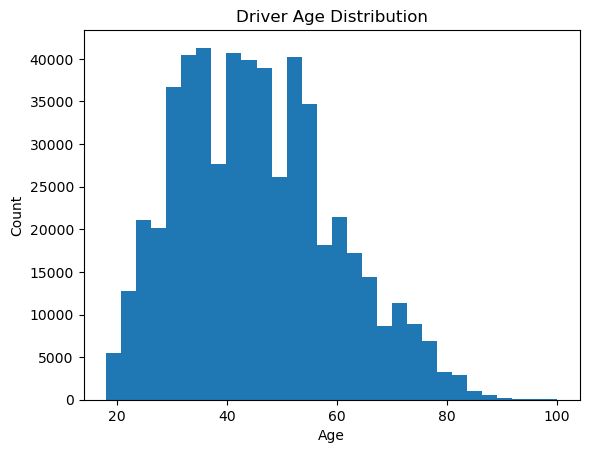

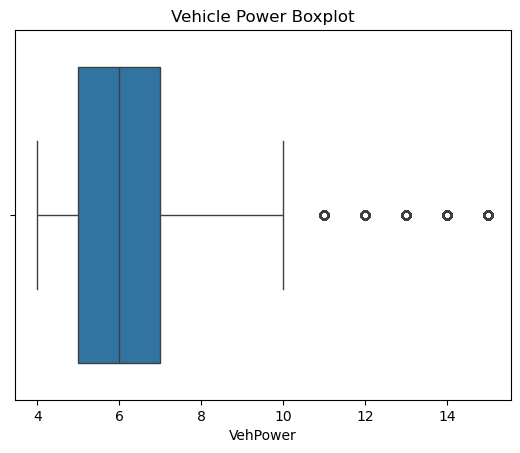

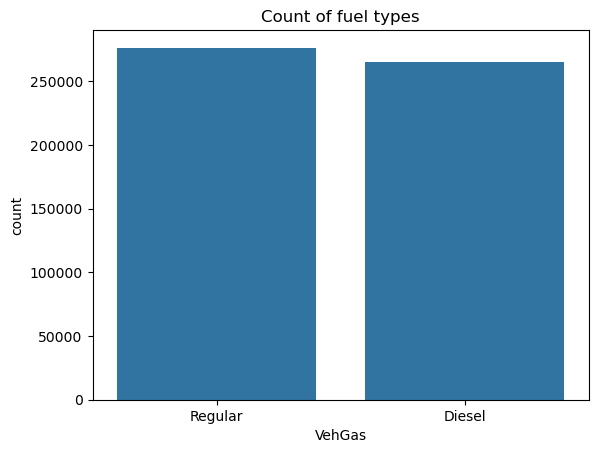

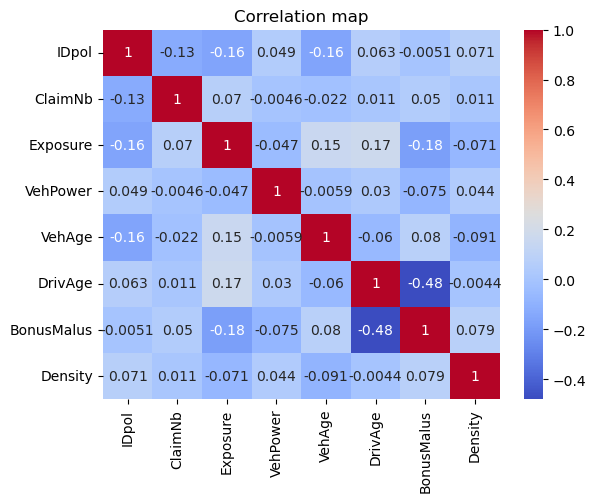

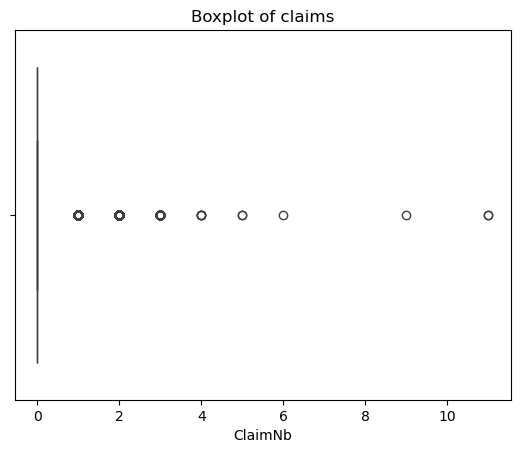

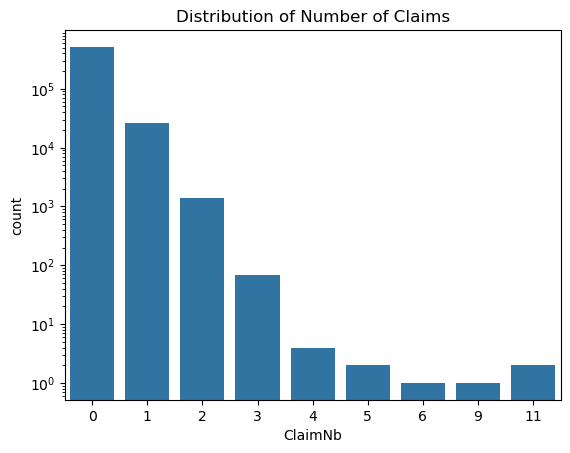

In [4]:
 #histogram of drivers age
plt.hist(train['DrivAge'],bins=30)  
plt.title('Driver Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()
 #boxplot of VehPower 
sns.boxplot(x=train['VehPower'])
plt.title('Vehicle Power Boxplot')
plt.show()
# Count of fuel types
sns.countplot(x=train['VehGas'])
plt.title('Count of fuel types')
plt.show()
# Heatmap of correlation of features     Noticed a neagative moderate correlation between driver age and BonusMalus, to be expected
corr=train.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation map')
plt.show()
#Boxplot of claims  Noticed that almost everyone has 0 claims
sns.boxplot(x=train['ClaimNb'])
plt.title('Boxplot of claims')
plt.show()
#Count plot with log scale on Y to see more clearly
sns.countplot(x='ClaimNb', data=train)
plt.yscale('log')  # use log scale to see rare values clearly
plt.title('Distribution of Number of Claims')
plt.show()

Adding 'Risk' column to datasets, target variable. Also, some plots with new Risk column. What features affect Risk ?


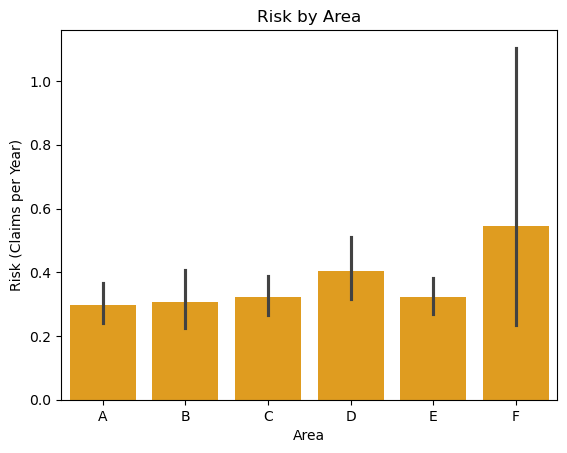

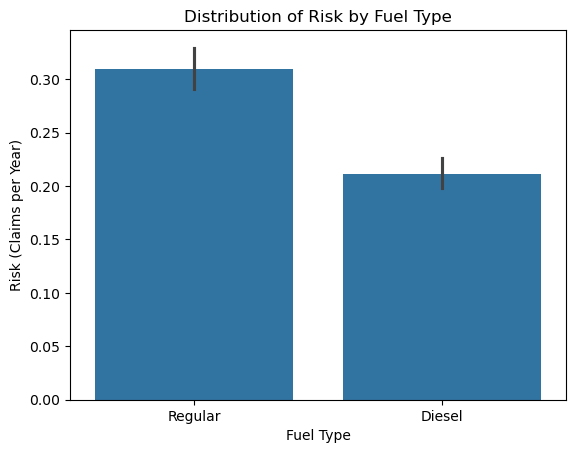

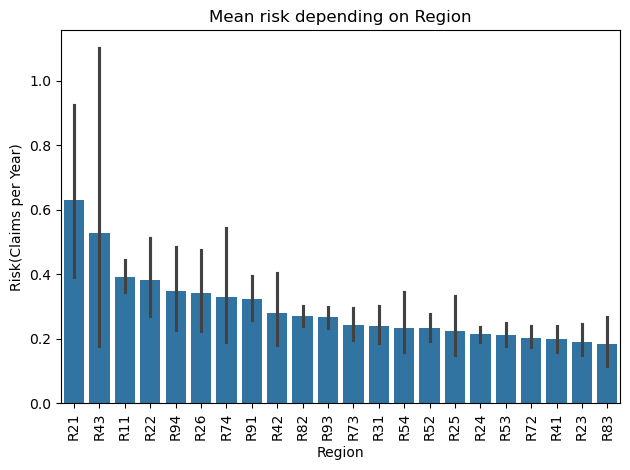

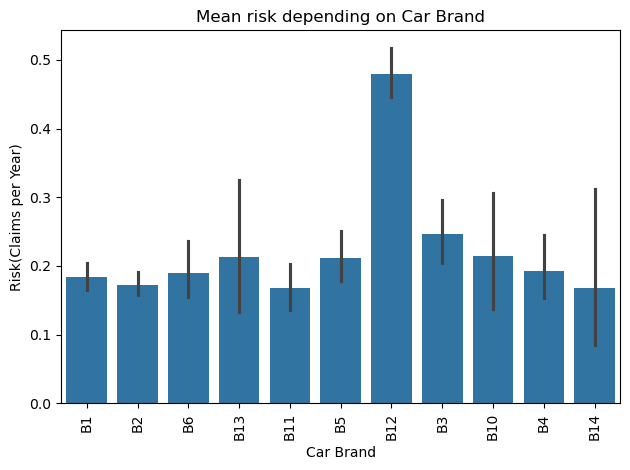

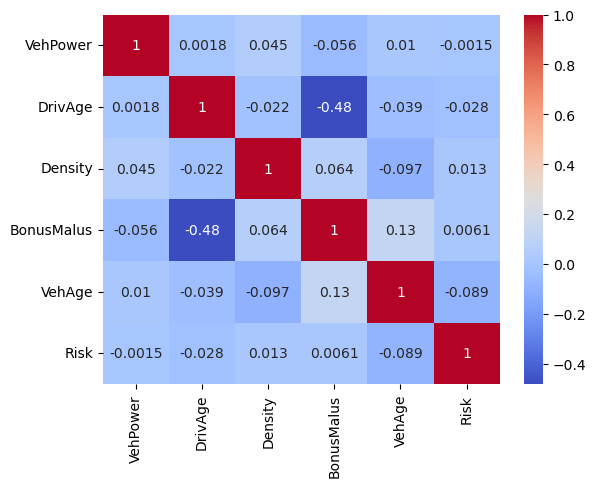

In [5]:
# Adding Risk column
train['Risk'] = train['ClaimNb'] / train['Exposure'] 
test['Risk'] =  test['ClaimNb'] / test['Exposure']


# Categorical features vs Risk

# Plot Area vs Risk   Seems like risk increases as area becomes more urbanistic
area_order = ['A', 'B', 'C', 'D', 'E', 'F']
sns.barplot(x='Area', y='Risk', data=test, color='orange', estimator='mean', order=area_order)
plt.title("Risk by Area")
plt.xlabel("Area")
plt.ylabel("Risk (Claims per Year)")
plt.show()

#  Plot of GasType and Risk. Seems like regular gas is a little more risky
sns.barplot(x='VehGas', y='Risk', data=train,estimator='mean')
plt.title("Distribution of Risk by Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Risk (Claims per Year)")
plt.show()

#Plot of Regions vs Risk         Not sure about this one. Maybe we can cetegorize R21 and R43 as high risk areas or something
region_means = (
    train.groupby('Region')['Risk']
    .mean()
    .sort_values(ascending=False)
    .index
)
sns.barplot(x='Region', y='Risk', data=train, estimator='mean', order=region_means)
plt.title('Mean risk depending on Region')
plt.xlabel('Region')
plt.ylabel('Risk(Claims per Year)')
plt.xticks(rotation=90)  # Rotate labels so they don't overlap
plt.tight_layout()
plt.show()

sns.barplot(x='VehBrand', y='Risk', data=train, estimator='mean')  # Noticed that B12 is more risky
plt.title('Mean risk depending on Car Brand')
plt.xlabel('Car Brand')
plt.ylabel('Risk(Claims per Year)')
plt.xticks(rotation=90)  # Rotate labels so they don't overlap
plt.tight_layout()
plt.show()
#Numeric features. Checking correlation with Risk  Doesn't seem to work, non-linear correlations are very weak. Useless

claims_train= train[train['Risk']>0] # I thought that maybe filtering out entries with 0 Risk would help,but nah
corr=claims_train[['VehPower','DrivAge', 'Density', 'BonusMalus','VehAge','Risk']].corr(numeric_only=True)
sns.heatmap(corr,annot=True,cmap='coolwarm')
plt.show()




Additional plots to dig deeper in finding relations between numeric features and Risk

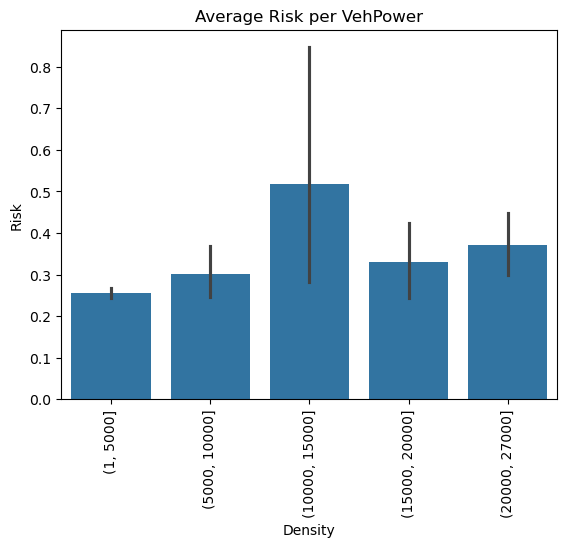

In [ ]:
# Age group vs Risk Younger tend to be more risky
train['AgeGroup'] = pd.cut(train['DrivAge'], bins=[18,25,35,50,65,100]) 
sns.barplot(x='AgeGroup', y='Risk', data=train)
plt.title("Average Risk by Driver Age Group")
plt.show()
#BonusMalus group vs Risk   At 200-250 range risk sky-rokets
sns.barplot(x=pd.cut(train['BonusMalus'], bins=[50,100,150,200,250]), y='Risk', data=train)
plt.title('Average Risk by BonusMalus group')
plt.show()
# VehPower vs Risk
sns.barplot(x=pd.cut(train['VehPower'], bins=[4,6,8,11]), y='Risk',data=train)
plt.title('Average Risk per VehPower')
plt.show()

sns.barplot(x=pd.cut(train['Density'], bins=[1,5000,10000,15000,20000,27000]), y='Risk',data=train)
plt.xticks(rotation=90)
plt.title('Average Risk per VehPower')
plt.show()



Encoding categorical variables and PCA visualization

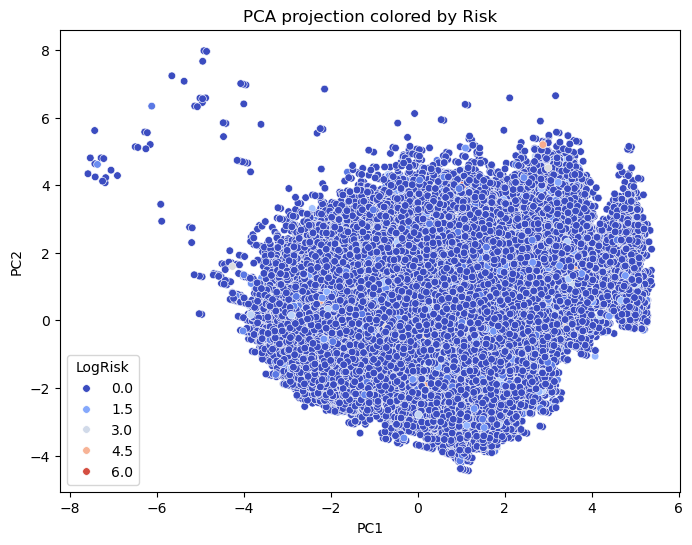

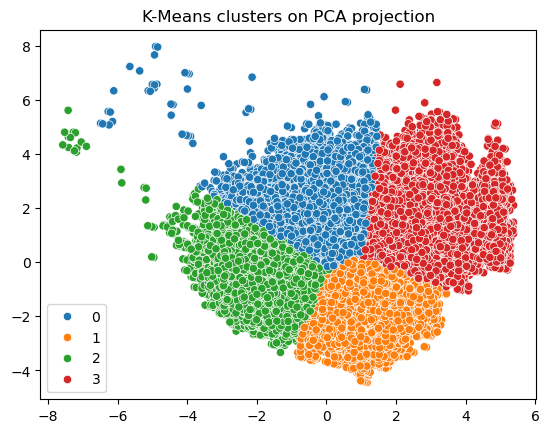

Cluster
0    0.060837
1    0.061504
2    0.062785
3    0.062347
Name: LogRisk, dtype: float64

In [ ]:
train_encoded=pd.get_dummies(train, columns=['VehBrand', 'VehGas', 'Region'], drop_first=True)#Encoding categorical values
area_map={'A':1,'B':2,'C':3,'D':4,'E':5,'F':6}
train_encoded['Area']=train_encoded['Area'].map(area_map) #Encoding order variable

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X=train_encoded.drop(columns=['Risk','ClaimNb','Exposure', 'IDpol'])
scaler = StandardScaler()                      #Standarizing numeric variables
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)         #Doing PCA
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Risk'] = train['Risk']
pca_df['Area'] = train['Area']
pca_df['Region'] = train['Region']

# Plot PCA colored by Risk
pca_df['LogRisk'] = np.log1p(pca_df['Risk'])  # log(1 + Risk)

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='LogRisk', palette='coolwarm', s=30)
plt.title('PCA projection colored by Risk')
plt.show()

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_pca)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='tab10')
plt.title('K-Means clusters on PCA projection')

plt.show()
pca_df['Cluster'] = clusters
pca_df.groupby('Cluster')['LogRisk'].mean()
#The features don’t show clear linear separation, so risk prediction will need supervised, nonlinear models such as Decision Trees and Neural Networks